# NICAR Workshop: Machine Learning and NLP #2

By Jeff Kao, ProPublica (jeff.kao[at]propublica.org)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

pd.options.display.max_columns = 50
pd.options.display.max_colwidth = 500

## Before you start: 
### Download and unzip the data
Save the twitter data to `./data`.
* web page: https://about.twitter.com/en_us/values/elections-integrity.html#data
* account data: https://storage.googleapis.com/twitter-election-integrity/hashed/ira/ira_users_csv_hashed.zip
* tweet data: https://storage.googleapis.com/twitter-election-integrity/hashed/ira/ira_tweets_csv_hashed.zip

Uncomment the below if you need to unzip the files.

In [6]:
# !ls ./data/

In [7]:
# !unzip ./data/ira_tweets_csv_hashed.zip -d ./data/

In [8]:
# !unzip ./data/ira_users_csv_hashed.zip -d ./data/

### Load the Data into memory

Let's load the `.csv` of user accounts into pandas.

In [9]:
%%time
df_users = pd.read_csv('./data/ira_users_csv_hashed.csv')

CPU times: user 63.6 ms, sys: 15.3 ms, total: 78.9 ms
Wall time: 85.3 ms


Let's load the `.csv` of tweets into pandas (might take a couple of minutes).

In [11]:
%%time
df_all = pd.read_csv('./data/ira_tweets_csv_hashed.csv')

<string>:2: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 1min 24s, sys: 13.1 s, total: 1min 37s
Wall time: 1min 38s


## Re-introduction

Wow, part 1 contained a lot of dataviz and ML! We're finally on our way to our ultimate goal. Clustering documents using NLP.

Let's reset for part 2.

### What did we just do?

In part 1, we used some off-the-shelf algorithms to reduce high-dimensional data and cluster it. We also visualized that process to gain an intuitive, high-level understanding of how these algorithms work.

### How is that useful?

Breaking down lots of text using NLP involves doing the same things that we did in part 1. The only difference is how the data is represented.

Instead of features in dimensions that represent pixel darkness or petal length, we need to obtain features that represent words as numbers. Once we can do that, we can visualize and cluster words-as-numbers in the same way!

### What if I didn't understand [insert idea here] in part 1?

It's a lot to go through at once, but a high-level understanding is enough if you have working code. As we play with the data, visualize it, and dig deeper into the algorithms (and possibly the math behind it), we'll get a better understanding of what's happening.

Again, I'll be posting these notebooks on [propublica's github](https://github.com/propublica) for your future use & play.

In [14]:
print(df_users.shape)
df_users.sample(5)

(3608, 10)


,userid,user_display_name,user_screen_name,user_reported_location,user_profile_description,user_profile_url,follower_count,following_count,account_creation_date,account_language
861,a9e00e3879c730a0ce856c4dc02af44570a4a5dc98d2687807a0cc595a0830b0,a9e00e3879c730a0ce856c4dc02af44570a4a5dc98d2687807a0cc595a0830b0,a9e00e3879c730a0ce856c4dc02af44570a4a5dc98d2687807a0cc595a0830b0,Одесса,Справжня дівчина,NaN,1052,96,2017-04-13,ru
428,a3384adbe62ff6c2bb08186ef33488cbd51be8ec4cc1167fc175114babd13ec0,a3384adbe62ff6c2bb08186ef33488cbd51be8ec4cc1167fc175114babd13ec0,a3384adbe62ff6c2bb08186ef33488cbd51be8ec4cc1167fc175114babd13ec0,NaN,NaN,NaN,15,238,2017-08-02,ru
1619,31c9ba13526333a8d6f30140075901ede051e3071d57e7ab357c3a855798d6f0,31c9ba13526333a8d6f30140075901ede051e3071d57e7ab357c3a855798d6f0,31c9ba13526333a8d6f30140075901ede051e3071d57e7ab357c3a855798d6f0,US,The person who says it cannot be done should not interrupt the person who is doing it.,NaN,92,46,2013-08-19,en
2325,947bda400668c820e19964532fa3f16a26c5bcf0b794a19891901931b3995b82,947bda400668c820e19964532fa3f16a26c5bcf0b794a19891901931b3995b82,947bda400668c820e19964532fa3f16a26c5bcf0b794a19891901931b3995b82,NaN,"не умею нормально одеваться, шутить, общаться, дружить, танцевать, вести отношения....",NaN,82,148,2014-04-29,ru
2870,6e15a45ba0a9df86391ac29aba3c611a04b2eb7110b53831153577cc02a2a1d5,6e15a45ba0a9df86391ac29aba3c611a04b2eb7110b53831153577cc02a2a1d5,6e15a45ba0a9df86391ac29aba3c611a04b2eb7110b53831153577cc02a2a1d5,USA,NaN,NaN,111,129,2013-08-24,en


In [13]:
print(df_all.shape)
df_all.sample(5)

(8768633, 31)


,tweetid,userid,user_display_name,user_screen_name,user_reported_location,user_profile_description,user_profile_url,follower_count,following_count,account_creation_date,account_language,tweet_language,tweet_text,tweet_time,tweet_client_name,in_reply_to_tweetid,in_reply_to_userid,quoted_tweet_tweetid,is_retweet,retweet_userid,retweet_tweetid,latitude,longitude,quote_count,reply_count,like_count,retweet_count,hashtags,urls,user_mentions,poll_choices
4656730,503867937607131136,c25d4558c0ad71b5d7ff6a2a34deaa833cd651d2a35338229f168e06b3d83138,c25d4558c0ad71b5d7ff6a2a34deaa833cd651d2a35338229f168e06b3d83138,c25d4558c0ad71b5d7ff6a2a34deaa833cd651d2a35338229f168e06b3d83138,Moscow,"Географ , Пробки от пивных бутылок #",NaN,64,24,2014-03-24,en,ru,Этому можно верить! Порошенко и Обаму будут публично судить! http://t.co/SjyiEkpxOs,2014-08-25 11:34,generationπ,NaN,NaN,NaN,False,NaN,NaN,absent,absent,0.0,0.0,0.0,0.0,NaN,[http://nobretract.livejournal.com/4718],NaN,NaN
8144958,654386367615631361,fa68e55511df85c409d0ed94c9a9e786f6fcf792584ca7a4d51bb3cb9037c5ca,fa68e55511df85c409d0ed94c9a9e786f6fcf792584ca7a4d51bb3cb9037c5ca,fa68e55511df85c409d0ed94c9a9e786f6fcf792584ca7a4d51bb3cb9037c5ca,Калининград,NaN,NaN,260,447,2014-03-09,en,ru,RT @MaxDementiev: Собака всегда похожа на своего хозяина http://t.co/WBRzGwLaj2,2015-10-14 20:00,bronislav,NaN,NaN,NaN,True,2808833544,6.543712e+17,absent,absent,0.0,0.0,0.0,0.0,[],[],[2808833544],NaN
2608634,606151556707307520,2d149ea064e6e264ca270a23989575da66a537e8682a6208ecd61fb16985348a,2d149ea064e6e264ca270a23989575da66a537e8682a6208ecd61fb16985348a,2d149ea064e6e264ca270a23989575da66a537e8682a6208ecd61fb16985348a,Воронеж,воронежский жеребец,NaN,128,397,2014-03-17,en,ru,@zubovnik гнойный пидор,2015-06-03 17:32,TweetDeck,6.061388e+17,2589513234,NaN,False,NaN,NaN,absent,absent,0.0,0.0,0.0,0.0,[],[],[2589513234],NaN
3570233,866407868043579392,2570631118,Politweecs,Politweecs,United States,Tweets and politics,NaN,36094,20288,2014-05-29,en,en,Trump told the Russians that firing Comey took the pressure off. This is what he should have said instead. https://t.co/etxF3lZ80o,2017-05-21 21:38,Twitter Web Client,NaN,NaN,NaN,False,NaN,NaN,absent,absent,0.0,0.0,0.0,0.0,[],[https://goo.gl/0BT4CR],NaN,NaN
5036756,799117714396708865,105597dbbc198c8cd7eac455cb3afe072345ea2aa3d391d77bd03bfeb610707e,105597dbbc198c8cd7eac455cb3afe072345ea2aa3d391d77bd03bfeb610707e,105597dbbc198c8cd7eac455cb3afe072345ea2aa3d391d77bd03bfeb610707e,"Москва, Россия","Человек, а это в наше время редкость!",NaN,2898,423,2014-05-04,ru,ru,RT @Batya_69: Молодые чиновники научились брать деньги из бюджета. Отлично! Но управлять они не способны. Жалкое подобие своих отцов. Мдассс,2016-11-17 05:11,Twitter Web Client,NaN,NaN,NaN,True,372370703,7.991121e+17,absent,absent,0.0,0.0,0.0,0.0,[],[],[372370703],NaN


Hmm, they're not all in english -- what language are people tweeting in?

In [22]:
df_users['account_language'].value_counts()[:10]

en       2382
ru       1039
de        111
ar         28
en-gb      15
fr         11
es          8
it          7
zh-cn       3
uk          2
Name: account_language, dtype: int64

In [23]:
df_all['tweet_language'].value_counts()[:10]

ru     4853185
en     2997181
und     229392
de       98460
uk       82237
bg       54690
ar       37241
it       20136
fr       12241
es       11922
Name: tweet_language, dtype: int64

Okay, that's a lot of users and a lot of tweets. Let's cut down on the tweets that we analyze by looking at english users and their english tweets, only.

In [20]:
%%time
df_users_eng = df_users[df_users['account_language'] == 'en']
df_eng = df_all[df_all['tweet_language'] == 'en']
df_eng = df_eng[df_eng['userid'].isin(df_users_eng['userid'])]

CPU times: user 2.34 s, sys: 539 ms, total: 2.88 s
Wall time: 2.88 s


There are also a lot of columns we don't need. Keep only the tweet-related columns we care about.

In [21]:
df_eng_red_cols = df_eng[['tweetid', 'userid',
       'tweet_text', 'tweet_time', 'tweet_client_name', 
       'in_reply_to_tweetid', 'in_reply_to_userid', 'quoted_tweet_tweetid', 
       'quote_count', 'reply_count', 'like_count', 'retweet_count',
       'is_retweet', 'retweet_userid', 'retweet_tweetid']]

It's easier to analyze documents when they're longer. Since tweets are so short, let's aggregate all of a user's tweets.

In [24]:
df_eng_by_user = \
(df_eng_red_cols[['userid','tweet_text']]
 .groupby('userid')
 .agg({'userid': 'first', 'tweet_text': lambda x: ' '.join(x)})
 .set_index('userid'))

Take a peek at what these users are saying.

In [28]:
df_eng_by_user.sample(5)

,tweet_text
userid,
394e51abc80b7ef91dc7d2aeef3a201fc5e5393c97baceeba54f8357ad3e2970,"RT @DeptofDefense: The @USArmyOldGuard honors fallen heroes by placing flags @ArlingtonNatl gravesites before #MemorialDay: https://t.co/aa… Every day is a #CarbDay! RT @StationCDRKelly: #MondayMotivation The colors of sunrise! https://t.co/CBCjwkJD1O RT @jnalsman: Tomorrow is #CarbDay! Carb now stands for carbohydrates in the beer that will be consumed tomorrow at @IMS. It's gonna be a… RT @Astro2fish: Alright, imagine the clouds are really thunder-clouds, then this looks like a wicked-ba..."
0bb9ff165ab81a5526043b6f5798e6dac30e663c0d1d0d9dd1a081cddf03278f,"RT @ArcadaTheatre: Last night I threw a private party for @JennyMcCarthy from her husband @DonnieWahlberg! Pink Floyd, Prime Rib &amp; more htt…"
ae023844ecbeea50820a894fcf356f99c8631dc2ae6d5652f2de9e36e771ac31,RT @TicketmasterUK: Don't miss out! @Coldplay's 4th @wembleystadium date on 15 June is on sale tomorrow 10:00!&gt; https://t.co/drv2CB8cb9 htt… #CNNDebate #VegasGOPDebate We waste too much money on #Syria and haven’t received anything in return RT @229217263f92580803d1f911d843306459e118a276d279464e5a7da268529598: Like Hillary is not gonna continue raping our economy! She totally supports his every decission #DEMDebate #DamnDebate RT @4ee74271f2d71ead3db0ce797a13ad93464796687f8fa35d9ddbb4692d...
618228e727579659187d37d818202a621bcef41d0e07cd99896c114d8c313970,RT @Novikovquisolge: http://t.co/nQqwTgObhZ Janay Rice @Petrovaenachsil Ukraine ex-minister injured as terror trial protesters clash with riot police TagScanner 5.1.645 Portable http://t.co/8gEBDIU904 texet t 920hd android http://t.co/btE8WVTJJh @ahezkoemokrd Take a tour of NYC on a giant circle made of skateboards. RT @8845477e608f36deabb38df17c0f2e04994bbf5ae149ff74633631decad09997: http://t.co/Vul9lcfko9 Twerking for Jesus @bbf27de8c9f37ffd3a416b6f44e5c5a8ba22896a40593540823657123aeb4f00 ...
c6dbc7c7851158af6632107003f9d731731b55d9ef85c9dbd8ab88d69fdb4ac9,"#IAmOnFire The two greatest FEAR busters are knowledge and action - Unknown #quotes RT @KevinGreen89: A terrible plant explosion happened at the #ColumbianChemicals Co in Centerville, LA RT @marthensasser: #ColumbianChemicals The information about plant explosion had been received from the witnesses http://t.co/bYSJd0Rc7c"


## Encoding Text as Numbers
We're finally ready to turn text into numbers! A couple of common techniques are bag-of-words and tfidf.

[Here's](http://datameetsmedia.com/bag-of-words-tf-idf-explained/) a short and straightforward explanation of the difference.

In [29]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

### Bag-of-words

In Scikit-learn, the `CountVectorizer` counts the number of words in your document and turns it into a vector.

In [30]:
count_vect = CountVectorizer(stop_words='english')

Let's count up the words in the text for our tweets (might take a couple of minutes):

In [31]:
%%time
X_counts = count_vect.fit_transform(df_eng_by_user['tweet_text'])

CPU times: user 41.8 s, sys: 1.39 s, total: 43.1 s
Wall time: 43.2 s


In [32]:
X_counts

<2191x1963375 sparse matrix of type '<class 'numpy.int64'>'
	with 6552422 stored elements in Compressed Sparse Row format>

So for each of the 2191 twitter accounts, the CountVectorizer has counted almost two million unique tokens! Each of these words is a feature or dimension in our dataset. That's far more dimensions than 4, or 64!

I'm curious: what are some the most frequent tokens in the dataset?

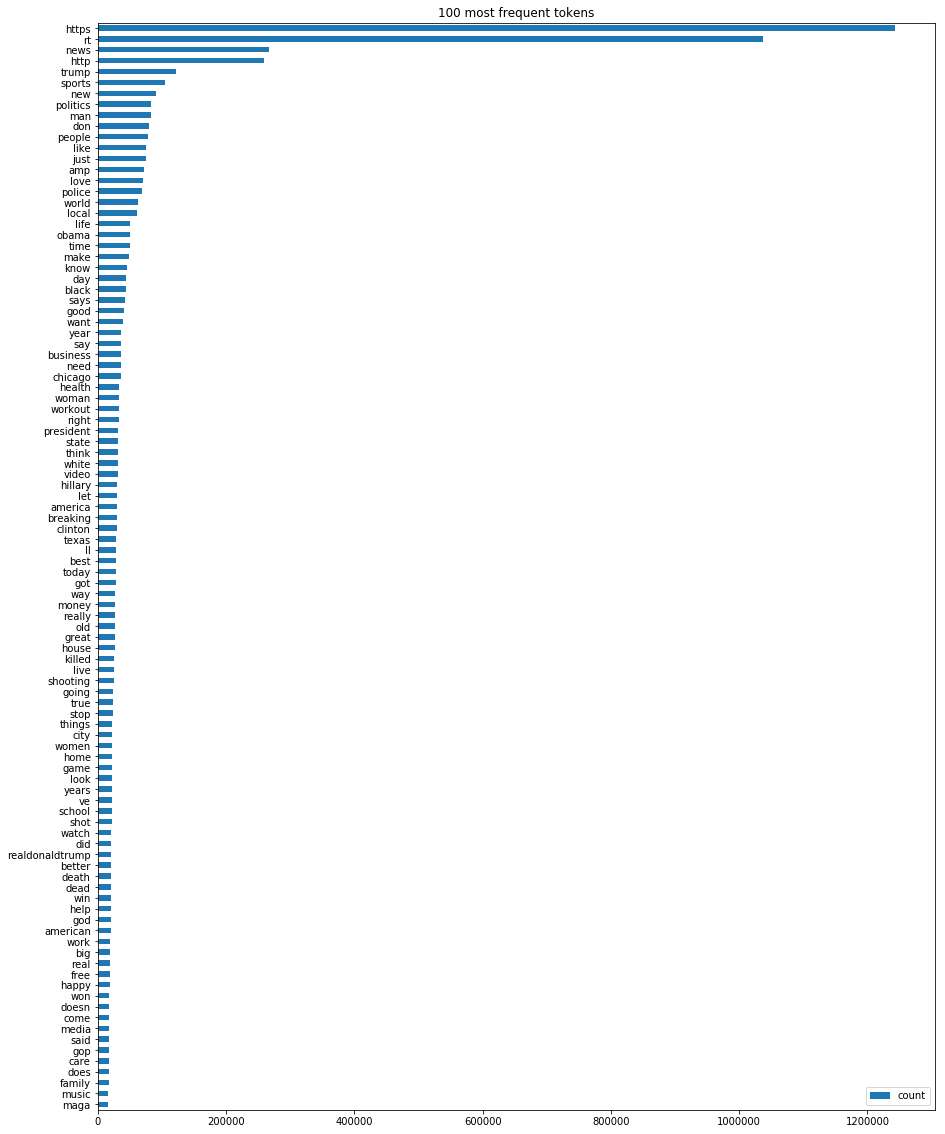

In [35]:
df_counts = (pd.DataFrame
             .from_dict(count_vect.vocabulary_, orient='index')
             .rename(columns={0: 'index'})
             .sort_values(by='index'))
df_counts['count'] = np.array(X_counts.sum(axis=0)).flatten()
df_counts = df_counts.drop(columns=['index'])
fig, ax = plt.subplots(figsize=(15,20))
ax.set_title('100 most frequent tokens')
df_counts.sort_values('count', ascending=False)[:100].sort_values('count').plot.barh(ax=ax);

### Tfidf
Short for term frequency, inverse document frequency. Basically, if the term appears too often (the document frequency is too high), it's not that important and we should divide it out.

In [36]:
tfidf_vect = TfidfVectorizer(stop_words='english')

Again, this will take a couple of minutes...

In [38]:
%%time
X_tfidfs = tfidf_vect.fit_transform(df_eng_by_user['tweet_text'])

CPU times: user 46.3 s, sys: 1.45 s, total: 47.7 s
Wall time: 47.8 s


In [39]:
X_tfidfs

<2191x1963375 sparse matrix of type '<class 'numpy.float64'>'
	with 6552422 stored elements in Compressed Sparse Row format>

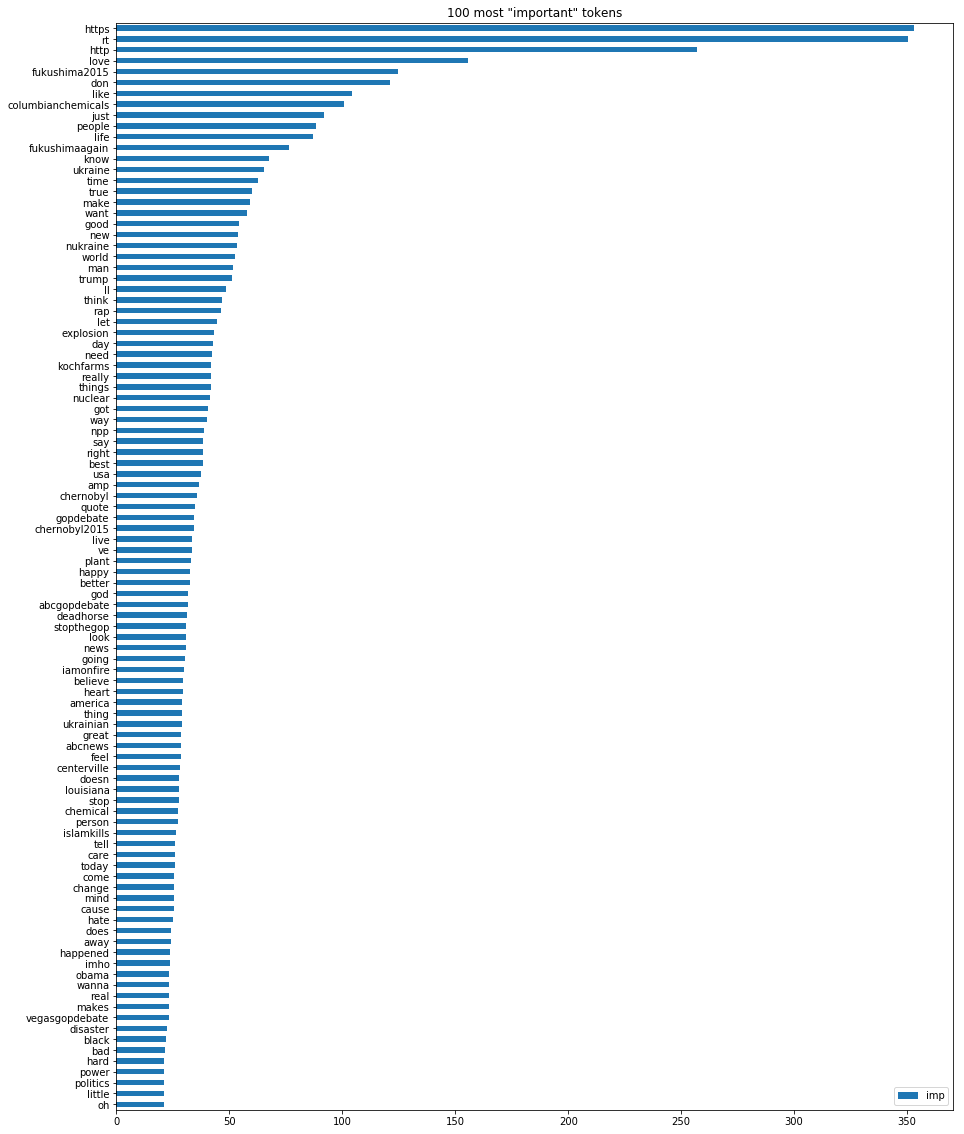

In [41]:
df_tfidfs = (pd.DataFrame
             .from_dict(tfidf_vect.vocabulary_, orient='index')
             .rename(columns={0: 'index'})
             .sort_values(by='index'))
df_tfidfs['imp'] = np.array(X_tfidfs.sum(axis=0)).flatten()
df_tfidfs = df_tfidfs.drop(columns=['index'])
fig, ax = plt.subplots(figsize=(15,20))
ax.set_title('100 most "important" tokens')
df_tfidfs.sort_values('imp', ascending=False)[:100].sort_values('imp').plot.barh(ax=ax);

Note: Summing Tfidf values and calling it 'importance' is kind of hand-wavy, but we can gloss over that for now.

## Dimensional Reduction

Remember, it's tough for our clustering algorithms to process high-dimensional data. We can use a dimensionality technique called SVD (very closely related to PCA) to reduce the number of dimensions to something more tractable. The combination of tfidf and SVD is actually a fairly well known algorithm called LSA (latent semantic analysis). 

Bonus tip: More on LSA [here](https://en.wikipedia.org/wiki/Latent_semantic_analysis).

In [42]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

In [57]:
svd = TruncatedSVD(n_components=100, random_state=42)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

Even longer...
This may seem like a long time, but we're not doing too bad for processing gigabytes of data!

In [58]:
%%time
X_lsa = lsa.fit_transform(X_tfidfs)

CPU times: user 2min 27s, sys: 20.1 s, total: 2min 47s
Wall time: 1min 31s


In [45]:
X_lsa.shape

(2191, 300)

Remember the idea of "explained variance"? We can ask SVD how much explained variance we retained.

Explained variance of the SVD step: 67%


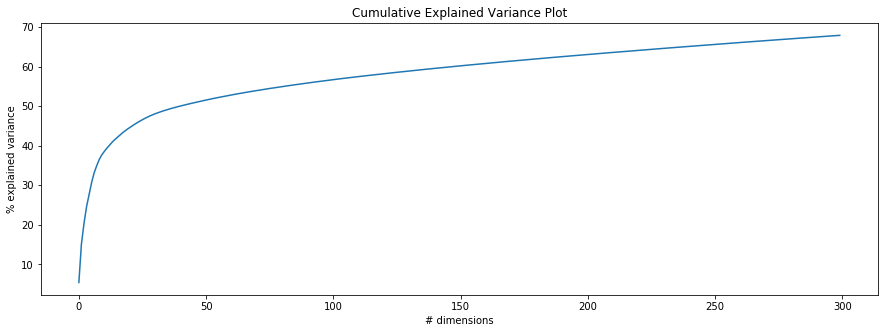

In [56]:
fig, ax = plt.subplots(figsize=(15,5))
df_ev.plot(ax=ax)
ax.set_title('Cumulative Explained Variance Plot')
ax.set_xlabel('# dimensions')
ax.set_ylabel('% explained variance')
ax.get_legend().remove()
df_ev = pd.DataFrame(data=svd.explained_variance_ratio_.cumsum()*100)
explained_variance = svd.explained_variance_ratio_.sum()
print(f"Explained variance of the SVD step: {int(explained_variance * 100)}%")

In [ ]:
import umap

In [ ]:
%%time

# Separate out the features
x = X_lsa

reducer = umap.UMAP()
um = reducer.fit_transform(x)
df_um = pd.DataFrame(
    data = um,
    columns = ['um1', 'um2']
)

In [ ]:
df_um.index = df_eng_by_user.index

In [ ]:
df_um

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(15,15)
)
sns.scatterplot(data=df_um, y='um2', x='um1', alpha=0.1, ax=ax);

In [ ]:
%%time

# Separate out the features
x = X_tfidfs

reducer = umap.UMAP()
um = reducer.fit_transform(x)
df_um = pd.DataFrame(
    data = um,
    columns = ['um1', 'um2']
)

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(15,15)
)
sns.scatterplot(data=df_um, y='um2', x='um1', alpha=0.1, ax=ax);

In [ ]:
# now we have documents in space -- we can visualize or use clustering algos!

## Machine Learning: NLP and Unsupervised learning

Supervised learning requires labelled data, but often when we are doing investigations, we don't yet know what we are looking for. Unsupervised learning helps our analysis because we let the numbers take us in the right direction.
* K-means
* HDBSCAN
* IsolationForest

## Twitter Dataset

## Data Exploration

## Natural Language Processing: Turning words to numbers

* bag-of-words (discuss bag-of-characters and n-grams)
* tfidf
* LSI
* we won't have time for:
* word2vec and other deep-learning based language models

## Natural Language Processing: Clustering and outlier detection

## Sample Analysis